<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading the Graph

In [3]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Facebook/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/My Drive/Colab Notebooks/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [4]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Colab Notebooks/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Colab Notebooks/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [5]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
        except:
            s1 = set()
        try:
            s2=set(train_graph.successors(row['source_node']))
        except:
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
        except:
            d1 = set()
        try:
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [6]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

In [7]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d'],
      dtype='object')

In [8]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [9]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

#Preferential Attachment with followers

In [10]:
df_final_train['preferential_attachment_followers']=df_final_train['num_followers_s']*df_final_train['num_followers_d']
df_final_test['preferential_attachment_followers']=df_final_test['num_followers_s']*df_final_test['num_followers_d']

#Preferential Attachment with followees

In [11]:
df_final_train['preferential_attachment_followees']=df_final_train['num_followees_s']*df_final_train['num_followees_d']
df_final_test['preferential_attachment_followees']=df_final_test['num_followees_s']*df_final_test['num_followees_d']

#svd dot

In [12]:
svd_u_s=np.array(df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])
svd_u_d=np.array(df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']])

df_final_train['svd_dot_u']=np.sum(svd_u_s*svd_u_d,axis=1)

svd_v_s=np.array(df_final_train[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])
svd_v_d=np.array(df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']])

df_final_train['svd_dot_v']=np.sum(svd_v_s*svd_v_d,axis=1)

In [13]:
svd_u_s=np.array(df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])
svd_u_d=np.array(df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']])

df_final_test['svd_dot_u']=np.sum(svd_u_s*svd_u_d,axis=1)

svd_v_s=np.array(df_final_test[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])
svd_v_d=np.array(df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']])

df_final_test['svd_dot_v']=np.sum(svd_v_s*svd_v_d,axis=1)

In [14]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'preferential_attachment_followers',
       'preferential_attachment_followees', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

#XGBoost

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

Estimators =  10 Train Score 0.9302179379715004 test Score 0.9264801835364441
Estimators =  30 Train Score 0.9643581629341123 test Score 0.9273667830256129
Estimators =  60 Train Score 0.9732092040003252 test Score 0.9325707022561169
Estimators =  100 Train Score 0.9767813603391235 test Score 0.9292543831753906
Estimators =  150 Train Score 0.9804348922859594 test Score 0.9289075416507694


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

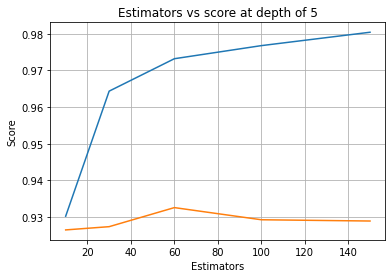

In [21]:
estimators =[10,30,60,100,150]
train_scores = []
test_scores = []
for i in estimators:
  xgb_model=XGBClassifier(max_depth=5,n_estimators=i,n_jobs=-1,random_state=25)
  xgb_model.fit(df_final_train,y_train)
  train_sc = f1_score(y_train,xgb_model.predict(df_final_train))
  test_sc = f1_score(y_test,xgb_model.predict(df_final_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.grid()
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9685407351959375 test Score 0.9232265155998985
depth =  9 Train Score 0.9796701576496964 test Score 0.9308652422255129
depth =  11 Train Score 0.9860670353915435 test Score 0.9281625037106146
depth =  15 Train Score 0.9971154423989903 test Score 0.9279918649238396
depth =  20 Train Score 0.9999500524449328 test Score 0.9290385388669022
depth =  35 Train Score 0.9999400635326554 test Score 0.9292467796179961
depth =  50 Train Score 0.9999400635326554 test Score 0.9290292556004485
depth =  70 Train Score 0.9999400635326554 test Score 0.9290292556004485
depth =  130 Train Score 0.9999400635326554 test Score 0.9290292556004485


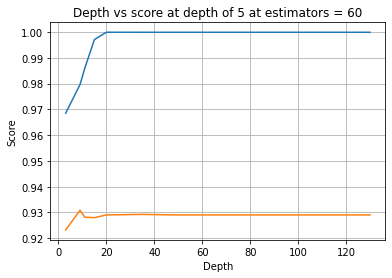

In [22]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
  xgb_model=XGBClassifier(max_depth=i,n_estimators=60,n_jobs=-1,random_state=25)
  xgb_model.fit(df_final_train,y_train)
  train_sc = f1_score(y_train,xgb_model.predict(df_final_train))
  test_sc = f1_score(y_test,xgb_model.predict(df_final_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.grid()
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 60')
plt.show()

In [25]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(55,75),
              "max_depth": sp_randint(10,16)}

xgb_model=XGBClassifier(random_state=25,n_jobs=-1)

xgb_randomcv = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',n_jobs=-1,random_state=25,return_train_score='True')

xgb_randomcv.fit(df_final_train,y_train)
print('mean test scores',xgb_randomcv.cv_results_['mean_test_score'])
print('mean train scores',xgb_randomcv.cv_results_['mean_train_score'])

mean test scores [0.97903597 0.9788247  0.97833605 0.97841448 0.97783036]
mean train scores [0.996794   0.99814983 0.99046219 0.99578649 0.98659236]


In [26]:
print(xgb_randomcv.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


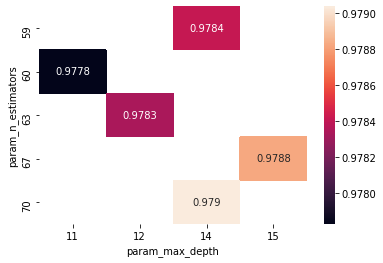

In [27]:
import seaborn as sn
results = pd.DataFrame(xgb_randomcv.cv_results_)

max_scores = results.groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sn.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

#Testing Performance of the Model with Best Hyper Parameters

In [28]:
xgb_model=XGBClassifier(max_depth=14,n_estimators=70,n_jobs=-1,random_state=25)

In [29]:
xgb_model.fit(df_final_train,y_train)
y_train_pred = xgb_model.predict(df_final_train)
y_test_pred = xgb_model.predict(df_final_test)

In [30]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9962612138525535
Test f1 score 0.9280189858665481


In [31]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


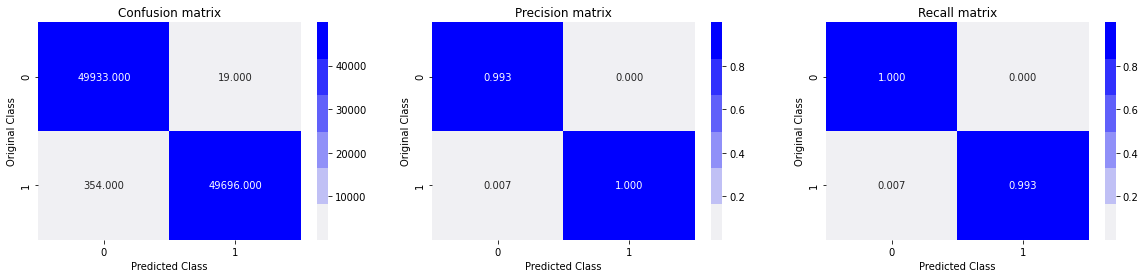

Test confusion_matrix


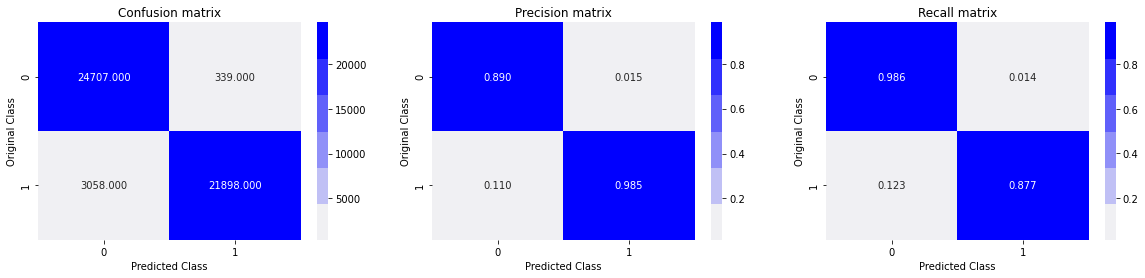

In [32]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

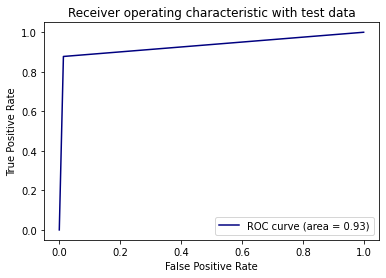

In [33]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

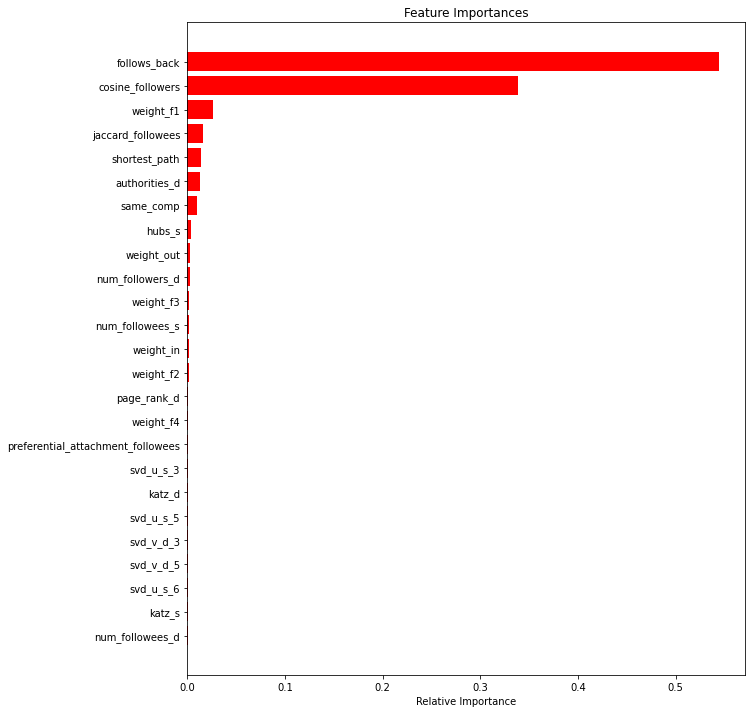

In [34]:
features = df_final_train.columns
importances = xgb_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Step by Step Procedure to solve Facebook Case Study
1.   First step is understanding the problem statement and accessing the data.
2.   Next We will perform Exploratory Data Analysis on the problem dataset and
collect the information from various analysis of the data. 
1.   Then we will be splitting the data into Train and Test Data and store into different files.
1.   we will be doing Featurization by adding set of features to both train and test data and storing data in seprate file.
1.   We will select a Model and train the model by tuning different HyperParameters.
1.   Train model with best Hyper Parameters and then we will be making predictons of the model.
2.   Finally testing performance of model using metrics f1 score,confusion matrix,precision,recall  and AUC(ROC Curve).
8.   We can also get the feature importances, the top features which helped in making predictions of the model.









